In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from init import download_data, plot_line, plot_hist, plot_box
from descriptive_analytics_fun import compute_CCreturns, get_AdjC

In [2]:
# downloading data starting from 10 years ago (120 months)
stocks = ["AAPL", "NVDA", "KO", "UL", "BAC", "AXP"]
dataframes = download_data(stocks = stocks, start_stream = '2010-06-01')
ccrs = {} # continuous compounds returns
# using cc returns due to his stationary characteristic
for df in dataframes:
    ccrs[df] = compute_CCreturns(dataframes[df], name = df)
    ccrs[df] = ccrs[df].to_frame()
    ccrs[df].columns = ['Target']

[] downloading AAPL	 -> Done
[] downloading NVDA	 -> Done
[] downloading KO	 -> Done
[] downloading UL	 -> Done
[] downloading BAC	 -> Done
[] downloading AXP	 -> Done


Splitto il dataset prendendo i primi 110 mesi su cui fare training e test (n e m), gli ultimi 10 mesi (l) sono dedicati alla parte di corecasting

Creo un dataset con `N + 1` colonne -> `[lag.1, lag.2, ..., lag.N, target]`. Le prime `N` colonne sono gli `N` giorni (o il periodo temporale scelto) precedenti a target che serviranno per stimare il valore di target (N-month average measurements). Generalmente `N = 3`

In [3]:
# READ HERE: stock_id contains the id of the share on which the forecast is made, 
# Write the id and than run ALL the notebook (Cell -> Run All)
stock_id = "AAPL"

N = 3
for i in range(N):
    ccrs[stock_id]['Lag.' + str(i+1)] = ccrs[stock_id]['Target'].shift(i+1)
ccrs[stock_id] = ccrs[stock_id].dropna()

# reorder columns
names_columns = list(ccrs[stock_id].columns[1:len(ccrs[stock_id].columns)])
ccrs[stock_id] = ccrs[stock_id].reindex(np.append(names_columns, ['Target']), axis=1)
print('dataset with lag columns: ')
# display(ccrs[stock_id])

df_lmonths = ccrs[stock_id].tail(10)
ccrs[stock_id] = ccrs[stock_id].head(len(ccrs[stock_id].index)-10)

print(f'\n{len(ccrs[stock_id].index)} months for training and testing: ')
display(ccrs[stock_id])
print(f'\n{len(df_lmonths.index)} months for forecasting: ')
display(df_lmonths)

dataset with lag columns: 

111 months for training and testing: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2010-10-31,0.085844,-0.014328,-0.024010,0.094308
2010-11-30,0.094308,0.085844,-0.014328,0.034790
2010-12-31,0.034790,0.094308,0.085844,0.031272
2011-01-31,0.031272,0.034790,0.094308,0.051216
2011-02-28,0.051216,0.031272,0.034790,0.037137
...,...,...,...,...
2019-08-31,0.061535,0.010144,-0.044666,0.001519
2019-09-30,0.001519,0.061535,0.010144,0.062681
2019-10-31,0.062681,0.001519,0.061535,0.076332



10 months for forecasting: 


,Lag.1,Lag.2,Lag.3,Target
Date,,,,
2020-01-31,0.052561,0.111937,0.076332,0.120431
2020-02-29,0.120431,0.052561,0.111937,-0.000212
2020-03-31,-0.000212,0.120431,0.052561,-0.170114
2020-04-30,-0.170114,-0.000212,0.120431,0.037183
2020-05-31,0.037183,-0.170114,-0.000212,0.131362
2020-06-30,0.131362,0.037183,-0.170114,0.110000
2020-07-31,0.110000,0.131362,0.037183,0.100235
2020-08-31,0.100235,0.110000,0.131362,0.206391
2020-09-30,0.206391,0.100235,0.110000,-0.018389


In [4]:
from sklearn.model_selection import train_test_split, cross_val_score

# Let's split the dataset
data = ccrs[stock_id].iloc[:,:N]
# data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

data_target = ccrs[stock_id].iloc[:,3]
# data_target contains only the Target column

In [5]:
# from sklearn
X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size = 0.25, random_state = 42)
# 25% of the data are used for test porpose (25% = 30 months)
# obv, train (X and y) are used to train the model, test to test it

In [6]:
# support vector machine for regression (SVR)
from sklearn.svm import SVR

# Hyperparameters optimization (SVM)
Cs = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
gammas = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilons = np.array([0.0001, 0.001, 0.01, 0.1 ])

opt_values = [np.inf, np.inf, np.inf, np.inf]
counter = 1

for a in Cs:
    for b in gammas:
        for c in epsilons:
            svm = SVR(kernel = 'rbf', C = a, gamma = b, epsilon = c)
            mse_svm = cross_val_score(svm, data, data_target, cv=10, scoring='neg_mean_squared_error')
            mse_svm = abs(np.average(mse_svm))
            
            # print("Iteration n. " + str(counter) + " MSE: " + str(mse_svm))
            
            if(opt_values[0] > mse_svm):
                opt_values[0] = mse_svm # actual value of mse
                opt_values[1] = a
                opt_values[2] = b
                opt_values[3] = c
                
            counter += 1

print("\nBest Model found:")
print("\tmse_svm: " + str(opt_values[0]))
print("\tC: " + str(opt_values[1]))
print("\tgamma: " + str(opt_values[2]))
print("\tepsilon: " + str(opt_values[3]))


Best Model found:
	mse_svm: 0.0036729018171904547
	C: 100.0
	gamma: 0.01
	epsilon: 0.001


In [7]:
svm = SVR(kernel='rbf', C=opt_values[1], gamma=opt_values[2], epsilon = opt_values[3])
display(svm)
svm_model = svm.fit(X_train, y_train)
pred_svm = svm_model.predict(X_test)
print('Testing')
display(pred_svm)

import joblib

# Save to file in svm_models directory in order to use it later
joblib.dump(svm_model, "./svm_models/svm_model_" + stock_id + ".pkl")

SVR(C=100.0, epsilon=0.001, gamma=0.01)

Testing


array([ 0.02932302,  0.04036027,  0.02712293,  0.00925841, -0.01917512,
       -0.01014426, -0.00597188,  0.02992201,  0.02308666,  0.01155395,
        0.02615908,  0.03241278,  0.02971001,  0.00522541,  0.05912309,
        0.00440713,  0.01446049,  0.02093774,  0.03077306,  0.00928541,
        0.03232863,  0.01038177, -0.00312019, -0.01459152,  0.01497593,
       -0.01174882,  0.0255475 ,  0.01772362])

['./svm_models/svm_model_AAPL.pkl']

In [8]:
print('Actual forecast on l months')

# Let's split the forecast's dataset
lmonths_data = df_lmonths.iloc[:,:N]
# lmonths_data contains Lag.1, Lag.2, ..., Lag.N columns (without Target column)

lmonths_data_target = df_lmonths.iloc[:,3]
# lmonths_data_target contains only the Target column

forecasted_values = svm_model.predict(lmonths_data)

compare = pd.concat([lmonths_data_target, 
                     pd.Series(forecasted_values, index=lmonths_data_target.index)], 
                    axis = 1).sort_values(by='Date')
compare.columns = ['Actual values', 'SVM predicted values']
display(compare)

from sklearn.metrics import mean_squared_error
mse_svm = mean_squared_error(compare.iloc[:, 0], compare.iloc[:, 1])
print(f'Mse between actual values and predicted ones: {mse_svm}')
print()
print(f'Sum of actual values (returns): \t\t {np.sum(compare["Actual values"])}')
print(f'Sum of predicted values (returns): \t {np.sum(compare["SVM predicted values"])}')

Actual forecast on l months


,Actual values,SVM predicted values
Date,,
2020-01-31,0.120431,0.032628
2020-02-29,-0.000212,0.052948
2020-03-31,-0.170114,0.016715
2020-04-30,0.037183,-0.022241
2020-05-31,0.131362,0.017368
2020-06-30,0.110000,0.027863
2020-07-31,0.100235,0.043910
2020-08-31,0.206391,0.050381
2020-09-30,-0.018389,0.075621


Mse between actual values and predicted ones: 0.010507430268659149

Sum of actual values (returns): 		 0.5312432187953565
Sum of predicted values (returns): 	 0.31303312790502513


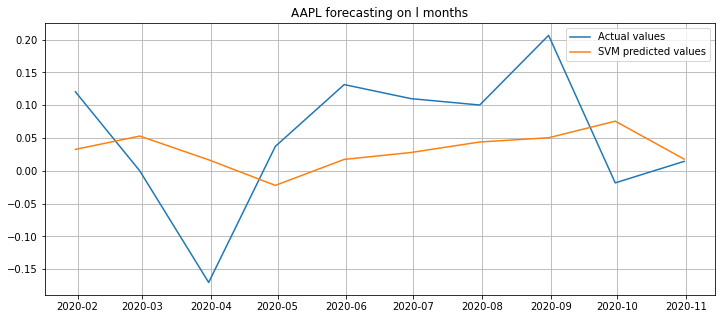

In [9]:
plt.figure(figsize = (12, 5))
plt.plot(compare.iloc[:, 0], label = 'Actual values')
plt.plot(compare.iloc[:, 1], label = 'SVM predicted values')
plt.title(f'{stock_id} forecasting on l months')
plt.grid()
plt.legend()
# plt.savefig('img_forecast/svm/'+ str(4) + '-forecast_svm_' + stock_id +'.png', dpi=300)
plt.show()